In [1]:
import sys
import os
import shutil
import json
import numpy as np

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])
sys.path.append(new_directory)

## Post processing framework

#### Simulation Name

In [16]:
simulation_name = 's1_wk'
simulation_folder = 'tests'

results_dir = os.path.sep.join(path_components[:-2])
results_path = os.path.join(results_dir,'.results',simulation_folder,simulation_name)
results_path = os.path.join(results_dir,'code','results',simulation_name)

main_path = os.path.join(results_dir,'code')
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_temp.py'))
print(main_path)
print(results_path)

/home/martinachondo/PINN/code
/home/martinachondo/PINN/code/results/s1_wk


In [17]:
folder_name = 'S_temp'
folder_path = os.path.join(main_path,'results',folder_name)

from S_temp import simulation

simulation.create_simulation()
print(simulation.domain_properties)

/home/martinachondo/PINN/code/Mesh/Mesh_softwares/MSMS/msms -if /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr -of /home/martinachondo/PINN/code/Molecules/Saved_meshes/Temp/born_ion_d40 -p 1.4 -d 40 -no_header
MSMS 2.6.1 started on tulio
Copyright M.F. Sanner (1994)
Compilation flags -O2 -DVERBOSE -DTIMING
Atom 2 ignored, radius = 0.010000
INPUT  /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr 1 spheres 0 collision only, radii  1.000 to  1.000
PARAM  Probe_radius  1.400 density 40.000 hdensity  3.000
REDUCED SURFACE ...
    1 free vertex (vertices) found
    RS component  #faces  #edges #free_edges  #vertices   genus
         0           0        1          0          1      1
    Time Reduced Surface real: 0.00 user: 0.00 sys: 0.00
ANALYTICAL SOLVENT EXCLUDED SURFACE...
    Component   0
        Time Surface real: 0.00 user: 0.00 sys: 0.00
    SES comp.  #fac.  #edg. #s_edg. #vert. #s_vert. R_h C_h genus
         0        1      0      0       0        0

Region point: Tensor({0}:-4.19792; {1}:6.46119; {2}:0.535869)
Delaunizing vertices...
Delaunay seconds:  0.02151
Creating surface mesh ...
Surface mesh seconds:  0.003128
Recovering boundaries...
Boundary recovery seconds:  0.003813
Removing exterior tetrahedra ...
Spreading region attributes.
Exterior tets removal seconds:  0.001177
Recovering Delaunayness...
Delaunay recovery seconds:  0.00553
Refining mesh...
  1468 insertions, added 1368 points, 50987 tetrahedra in queue.
  488 insertions, added 419 points, 58593 tetrahedra in queue.
  651 insertions, added 437 points, 58852 tetrahedra in queue.
  868 insertions, added 312 points, 108 tetrahedra in queue.
Refinement seconds:  0.082653
Smoothing vertices...
Mesh smoothing seconds:  0.127673
Improving mesh...
Mesh improvement seconds:  0.004765

Writing nodes.
Writing elements.
Writing faces.
Writing edges.

Output seconds:  0.000664
Total running seconds:  0.251238

Statistics:

  Input points: 1102
  Input facets: 2196
  Input segm

In [19]:
Iter = 5000
simulation.load_model(folder_path,results_path,Iter, save=False)
Post = simulation.Post

In [20]:
df = Post.save_values_file(save=False)
print(json.dumps(df, indent=4))

{
    "Gsolv_value": "-145.642",
    "L2_continuity_u": "1.023e-03",
    "L2_continuity_du": "1.576e-02",
    "Loss_XPINN": "4.931e-01",
    "Loss_NN1": "3.323e-02",
    "Loss_NN2": "3.892e-03",
    "L2_analytic": "1.073e+03"
}


In [21]:
Post.PDE.get_solvation_energy(Post.XPINN.model)

-179.43008996243734

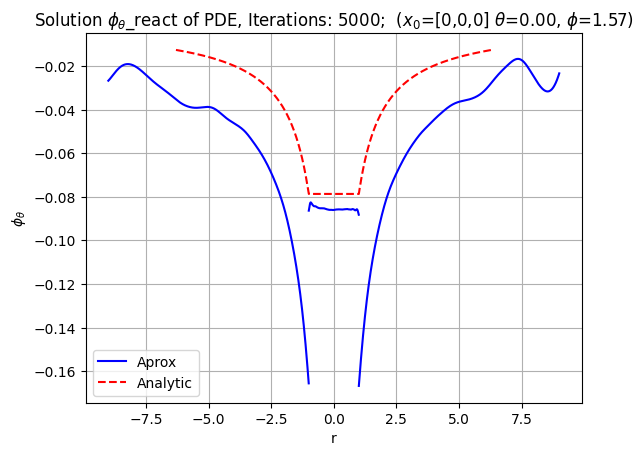

In [22]:
Post.plot_aprox_analytic(value='react')

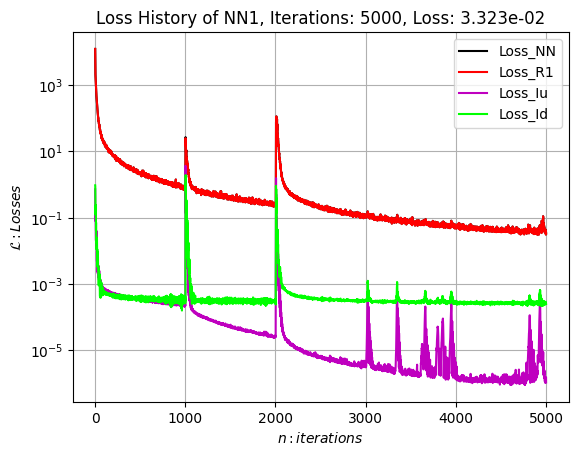

In [23]:
Post.plot_loss_history(domain=1)

#### Computations

In [14]:
import bempp.api

u_interface,_,_ = Post.PDE.get_phi_interface(*Post.NN)
u_interface = u_interface.flatten()
_,du_1,du_2 = Post.PDE.get_dphi_interface(*Post.NN)
du_1 = du_1.flatten()
du_2 = du_2.flatten()
du_1_interface = (du_1+du_2*Post.NN[1].PDE.epsilon/Post.NN[0].PDE.epsilon)/2

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

phi_q = Post.PDE.slp_q * dphi - Post.PDE.dlp_q * phi

slp_aprox = Post.PDE.slp_q * dphi
dlp_aprox = Post.PDE.dlp_q * phi

In [15]:
print('slp',slp_aprox)
print('dlp', dlp_aprox)

slp [[-0.04577357]]
dlp [[-0.00114817]]


In [16]:
Rs = np.linalg.norm(Post.PDE.mesh.mol_verts, axis=1)

u_interface = Post.PDE.analytic_Born_Ion(Rs)
du_1_interface = Post.PDE.analytic_Born_Ion_du(Rs)

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

slp_an = Post.PDE.slp_q * dphi
dlp_an = Post.PDE.dlp_q * phi

In [17]:
print('slp',slp_an)
print('dlp', dlp_an)

slp [[-0.07938546]]
dlp [[-0.00094506]]


In [18]:
def get_Gsolv(slp,dlp):
  phi_q = slp - dlp
  G_solv = 0.5*np.sum(Post.PDE.qs * phi_q).real
  G_solv *= Post.PDE.to_V*Post.PDE.qe*Post.PDE.Na*(10**-3/4.184) 
  return G_solv

In [19]:
print('aprox',get_Gsolv(slp_aprox,dlp_aprox))
print('an',get_Gsolv(slp_an,dlp_an))

aprox -93.10722575405698
an -163.65945134158008


In [20]:
print('ap-an',get_Gsolv(slp_aprox,dlp_an))
print('an-ap',get_Gsolv(slp_an,dlp_aprox))

ap-an -93.53099959788352
an-ap -163.23567749775356
